In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import prince
import importlib





import utils2
from utils2 import *
import graphfunk
from graphfunk import *


## Graph Overview - CA Prep

- In this notebook, I will perform various check in order to make sure my data is ready for CA implementation

- This includes:
    - Data distribution checks
    - Node and edge analysis; various graph metrics and visualisations. Are there any clusters etc?
    - Assumptions of CA?
    - Connectedness of my graph

I'm starting with an edge list. Each row represents an edge (a follower-brand relationship) in the graph. From the edge list, I should create a directed graph. 

In [11]:
#Load the edge list
#Load marker followers
full_path1 = '/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

edgelist = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

In [4]:
summary_stats(edgelist)

Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Data types of columns:
 marker_id      object
follower_id    object
dtype: object

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  0


In [13]:
#Add twitter name, type, and followers to the edge list for more informative plots at a later stage

# Full path to the Excel file where types and names of brands are stored
file_path = '/home/livtollanes/SocialMarkers/MarkersFrenchTwitter.xlsx'

# Load the Excel file
cats = pd.read_excel(file_path)

The excel file does not contain twitter ID. We thus need to merge cats with the marker metadata file in order to get names and ids in the same df

In [14]:
# Load the marker bios and rename ID columns
full_path = '/home/livtollanes/SocialMarkers/markers_bios_2023-05-19.csv'

req_cols = ['twitter_name', 'id', 'tweets', 'followers']

dtypes = {
    'twitter_name': 'object',
    'id': 'object',
    'description': 'object',
    'tweets': 'int64',
    'followers': 'int64'}

marker_ids = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes)

#rename the twittwer id column to follower id 
marker_ids.rename(columns={'id':'marker_id'}, inplace=True)

In [15]:
#map marker_ids onto cats from marker:ids
cat_id = cats.merge(marker_ids, on='twitter_name', how='left')
cat_id = cat_id.drop_duplicates(subset='marker_id')

In [17]:
#streamline cat_id and edge list. Only include ids in cat id that exist in edge list
cat_id = streamline_IDs(edgelist, cat_id, 'marker_id')

Number of unique marker_id in source DataFrame: 235
Number of unique marker_id in filtered DataFrame after filtering: 235
Removed 2 rows from the DataFrame to be filtered.
235 rows are left in the filtered DataFrame.


In [18]:
cat_id.columns

Index(['marque', 'twitter_name', 'type', 'Unnamed: 3', 'marker_id', 'tweets',
       'followers'],
      dtype='object')

In [19]:
cat_id_nodupes = cat_id.drop_duplicates()

#Get the twitter_name column from cat_id into the edge list by merging on marker_id
edgelist = edgelist.merge(cat_id[['marker_id', 'twitter_name', 'type', 'followers']], on='marker_id', how='left')


In [23]:
summary_stats(edgelist)

Shape of DataFrame:  (9614122, 5)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers']

Data types of columns:
 marker_id        object
follower_id      object
twitter_name     object
type             object
followers       float64
dtype: object

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0
'twitter_name':  0
'type':  0
'followers':  0

Number of duplicate rows:  0


Informative subset (Optional)

#It might be a good idea to use the most informative subset of my data, like in the original study (He and Tsvetkova.) They selected users who follow at least one brand across all their brand domains. I have more domains thn them (12 vs. 6). The chance that people follow all 12 is small. If I am to filter my data like they do, it maybe makes more sense to look at people who follow at least half of the brands. 

In [9]:
#inspect the marker_bios data for marker_ID 1059975643
row = cat_id.loc[cat_id['marker_id'] == '1059975643']

# Print the row
print(row)

        marque  twitter_name   type Unnamed: 3   marker_id description  \
18  Napapijiri  Napapijiri97  sport        NaN  1059975643         NaN   

    verified  tweets  followers  
18       0.0     8.0        1.0  


Make dge list into a graph.
An edge list is a simple, tabular representation of a graph, while a graph is amore complex data structure that allows for more advance operations, such s finding paths and calculating graph metrics.

### Graph metrics

In [12]:

# Create a new bipartite graph
B = nx.DiGraph() #directed graph

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(edgelist['follower_id'].unique(), bipartite=0) #adding a node for each unique follower. Set 1 in the bipartite graph
B.add_nodes_from(edgelist['twitter_name'].unique(), bipartite=1) #adding a node for each unique marker. Set 2 in the bipartite graph
 
# Add edges
B.add_edges_from(list(zip(edgelist['follower_id'], edgelist['twitter_name'])))  #edges are directed from the first to the second element. So direction is; follower --> Marker

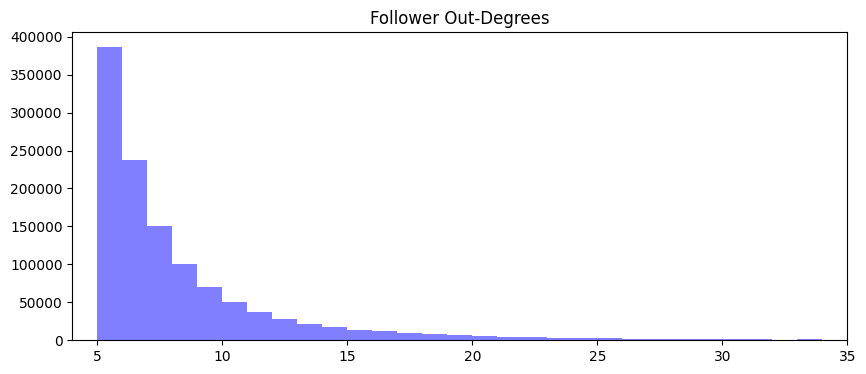

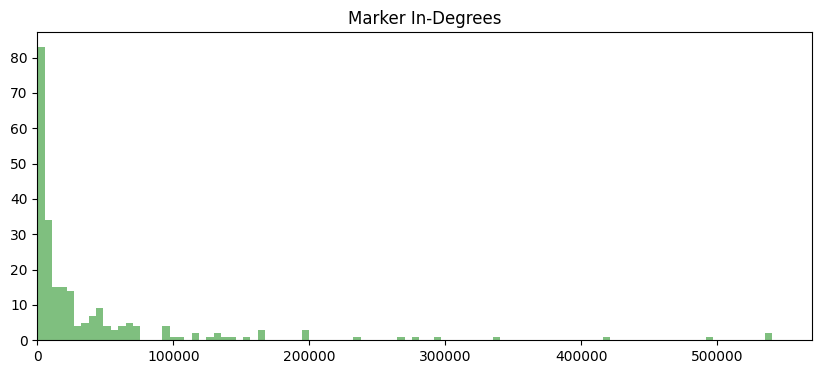

In [19]:
# Analyse and visualise degree distribution (number of edges connected to each node)

# Separate the nodes by type
follower_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
marker_nodes = set(B) - follower_nodes

# Calculate the out-degree of each follower node and in-degree of each marker node
follower_out_degrees = [B.out_degree(n) for n in follower_nodes]
marker_in_degrees = [B.in_degree(n) for n in marker_nodes]

# Plot the out-degree distribution of follower nodes
bins = range(4, 35)

plt.figure(figsize=(10, 4))
plt.hist(follower_out_degrees, bins = bins, alpha=0.5, color='blue')
plt.title('Follower Out-Degrees')
plt.xlim(4, 35)
plt.show()

# Plot the in-degree distribution of marker nodes
plt.figure(figsize=(10, 4))
plt.hist(marker_in_degrees, bins = 100, alpha=0.5, color='green')
plt.title('Marker In-Degrees')
plt.xlim(0, 570000)
plt.show()

- As we can see based on the marker in-degrees plot, a select few brans have a lot of connections compared to teh rest of the markers
- From the follower Out-degree plot, it is evident that most users don't follow more than 10 brands. Following more than 15 brands is even less normal. 

In [20]:
# Calculate weakly connected components
connected_components = list(nx.weakly_connected_components(B))

# Print the number of connected components
print("Number of connected components:", len(connected_components))

# Print the size of the largest connected component
print("Size of largest connected component:", max(len(c) for c in connected_components))

Number of connected components: 1
Size of largest connected component: 1192767


A weakly connected component is a subgraph of the original graph where all vertices are connected to each other by some path, ignoring the direction of edges. Given our number of connected components is 1, we can conclude that our graph is fully connected. 

In [21]:
# Calculate in-degree centrality for all nodes in the graph
in_degree_centrality = nx.in_degree_centrality(B)

# Top 5 nodes by in-degree centrality
top_in_degree_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top nodes by in-degree centrality:", top_in_degree_nodes)



Top nodes by in-degree centrality: [('Dior', 0.45296311263064176), ('LouisVuitton', 0.45275938448949754), ('CHANEL', 0.41497242543801555), ('YSL', 0.34924369071553013), ('Nike', 0.28177781727514034)]


In [74]:
# Number of brands
num_brands = len(edgelist['twitter_name'].unique())

# Calculate out-degree for each follower and divide by the number of brands
out_degree_centrality = {follower: out_degree / num_brands for follower, out_degree in B.out_degree() if B.nodes[follower]['bipartite'] == 0}

# Top 5 nodes by out-degree centrality
top_out_degree_nodes = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top nodes by out-degree centrality:", top_out_degree_nodes)

Top nodes by out-degree centrality: [('35704105', 0.6340425531914894), ('107042704', 0.4595744680851064), ('1430557124132839431', 0.4425531914893617), ('525429842', 0.4127659574468085), ('819576166055104516', 0.40425531914893614)]


In [ ]:
#Some users follow a lot of brands. Maybe a bit unlikely?
top_followers = edgelist.groupby('follower_id').size().sort_values(ascending=False).head(5)
print(top_followers)

In [75]:
summary_stats(edgelist, print_dtypes=True)

Shape of DataFrame:  (9730265, 3)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name']

Data types of columns:
 marker_id       object
follower_id     object
twitter_name    object
dtype: object

Number of unique values in 'follower_id':  1192532

Number of duplicate values in 'follower_id':  8537733

Number of unique values in 'marker_id':  235

Number of duplicate values in 'marker_id':  9730030

Number of missing values in each column:
 marker_id       0
follower_id     0
twitter_name    0
dtype: int64


In [24]:
#Save edgelist to csv 
edgelist.to_csv('/home/livtollanes/NewData/edgelist.csv', index=False, encoding='utf-8')

## The CA

- Create contingency table (rows are users, columns are brands)
- each cell represents the frequency of interaction between user and brand


In [3]:
# load data
path = '/home/livtollanes/NewData/edgelist.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'type': 'object',
          'followers': 'int64'}


edgelist_CA = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [32]:
edgelist_CA.head()

,marker_id,follower_id,twitter_name,type,followers
0,415859364,1301293067945807877,Nike,sport,9788339
1,415859364,1233001848006729729,Nike,sport,9788339
2,415859364,2768568386,Nike,sport,9788339
3,415859364,1152271993225433089,Nike,sport,9788339
4,415859364,947287974882021377,Nike,sport,9788339


In [4]:
#creating the contingency table
contingency_table = pd.crosstab(edgelist_CA['follower_id'], edgelist_CA['twitter_name'])

In [5]:
# Initialize a CA object
ca = prince.CA(
    n_components=3,  # Number of components to keep
    n_iter=10,  # Number of iterations for the power method
    copy=True,  # Whether to overwrite the data matrix
    check_input=True,  # Whether to check the input for NaNs and Infs
    engine='sklearn',  # Whether to perform computations in C or Python
    random_state=42  # Random seed for reproducibility
)

# Fit the CA model on the contingency table
ca = ca.fit(contingency_table)

# Get the coordinates of the rows (followers) and columns (brands) on the first two components
row_coordinates = ca.row_coordinates(contingency_table)
column_coordinates = ca.column_coordinates(contingency_table)

print("Row Coordinates:\n", row_coordinates)
print("Column Coordinates:\n", column_coordinates)

Row Coordinates:
                             0         1         2
follower_id                                      
1000000204685312001  0.629827 -2.043692 -1.141925
1000000325695262720  0.937719  0.388769  0.403210
1000000540829417472  0.016897 -1.113688  0.714949
1000004748681072640 -0.935134  0.281821  0.008673
1000005920372518912  0.764223 -0.752355  1.888794
...                       ...       ...       ...
999992864313692160   0.854611  0.011727  0.847312
999994160           -1.160955  0.166750  0.041802
999997228726013953   1.029317  0.718458 -0.050928
999998065712025600   0.474237 -1.801325 -1.089761
999998477307404288   0.551979 -2.131551 -1.179584

[1192532 rows x 3 columns]
Column Coordinates:
                         0         1         2
twitter_name                                 
24heuresactu     0.911811  0.671406  0.022413
ACAjaccio        0.574993 -2.061257 -1.377884
AJA              0.631213 -2.046493 -1.137964
ASICSFrance      0.433976 -0.678342  0.672704
AS_Mona

In [7]:
ca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.808,3.41%,3.41%
1,0.594,2.51%,5.92%
2,0.449,1.90%,7.82%


In [9]:
ca.column_contributions_.style.format('{:.0%}')

,0,1,2
24heuresactu,0%,0%,0%
ACAjaccio,0%,2%,1%
AJA,0%,2%,1%
ASICSFrance,0%,0%,0%
AS_Monaco,0%,5%,2%
AUCHAN_France,0%,0%,3%
Actu17,0%,0%,0%
AgroParisTech,0%,0%,0%
AlterEco_,1%,1%,0%
AmazonFrance,0%,0%,0%


In [9]:
# Create a DataFrame with unique 'marker_id' and corresponding 'type'
unique_marker_df = edgelist_CA.drop_duplicates(subset='marker_id')[['marker_id', 'twitter_name', 'type']]

In [42]:
unique_marker_df.head()

,marker_id,twitter_name,type
0,415859364,Nike,sport
336095,25487201,adidasFR,sport
398795,18481641,Lacoste,sport
595229,183398746,Converse,sport
733590,187897893,Moncler,sport


/tmp/ipykernel_352060/3738020864.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))


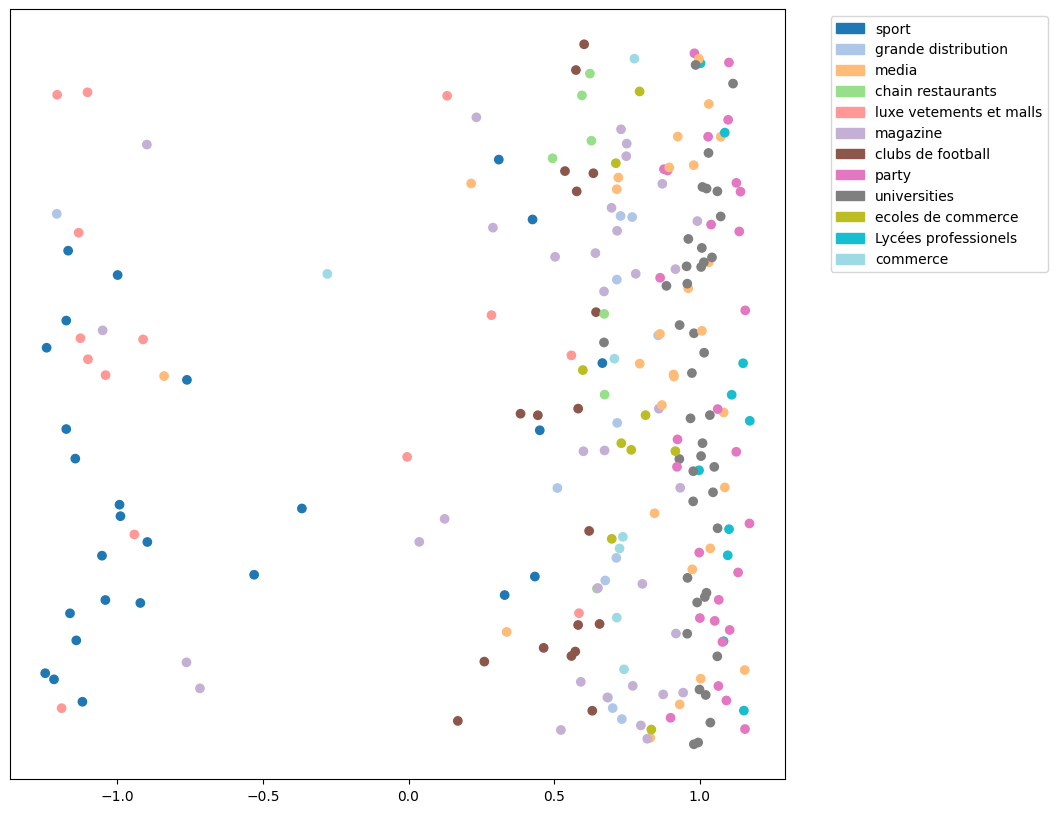

In [43]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
import numpy as np

# Create a color map
types = unique_marker_df['type'].unique()
cmap = cm.get_cmap('tab20', len(types))

# Get the colors for the brands
colors = unique_marker_df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

# Fill missing colors with 'black'
colors = colors.reindex(column_coordinates.index, fill_value='black')

# Create a scatter plot
plt.figure(figsize=(10, 10))

# Create a smaller jitter
jitter = 0.01 * np.random.rand(len(column_coordinates.index))

# Use all possible twitter_names in column_coordinates
plt.scatter(column_coordinates[0], jitter, c=colors)

# Create a legend
legend_elements = [Patch(facecolor=cmap(i), edgecolor=cmap(i), label=type_) for i, type_ in enumerate(types)]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.yticks([])

plt.show()

In [81]:
import graphfunk

/home/livtollanes/10.jan-thesis/Code/graphfunk.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(column_coordinates_type_sorted[0][i], y_values[i], twitter_name))


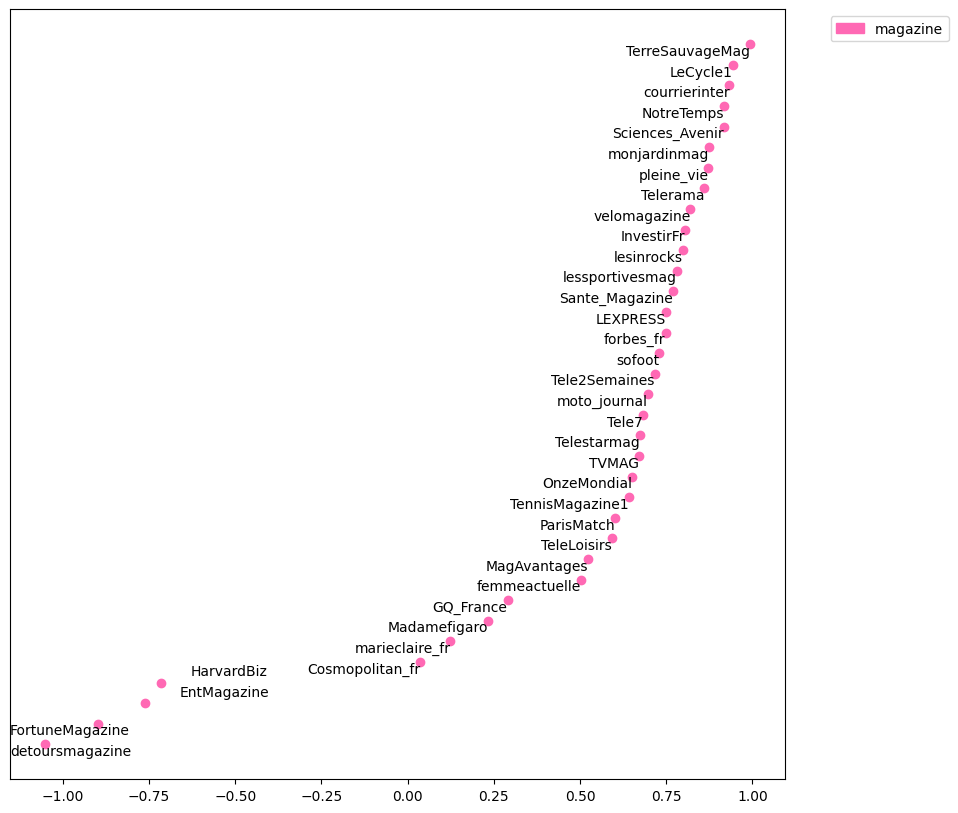

In [99]:
# Call the function with 'sport' type
importlib.reload(graphfunk)

#graphfunk.plot_type(unique_marker_df, column_coordinates, 'sport', 'skyblue')
#graphfunk.plot_type(unique_marker_df, column_coordinates, 'luxe vetements et malls', 'turquoise')
graphfunk.plot_type(unique_marker_df, column_coordinates, 'magazine', 'hotpink')

#graphfunk.plot_type(unique_marker_df, column_coordinates, 'grande distribution', 'green')


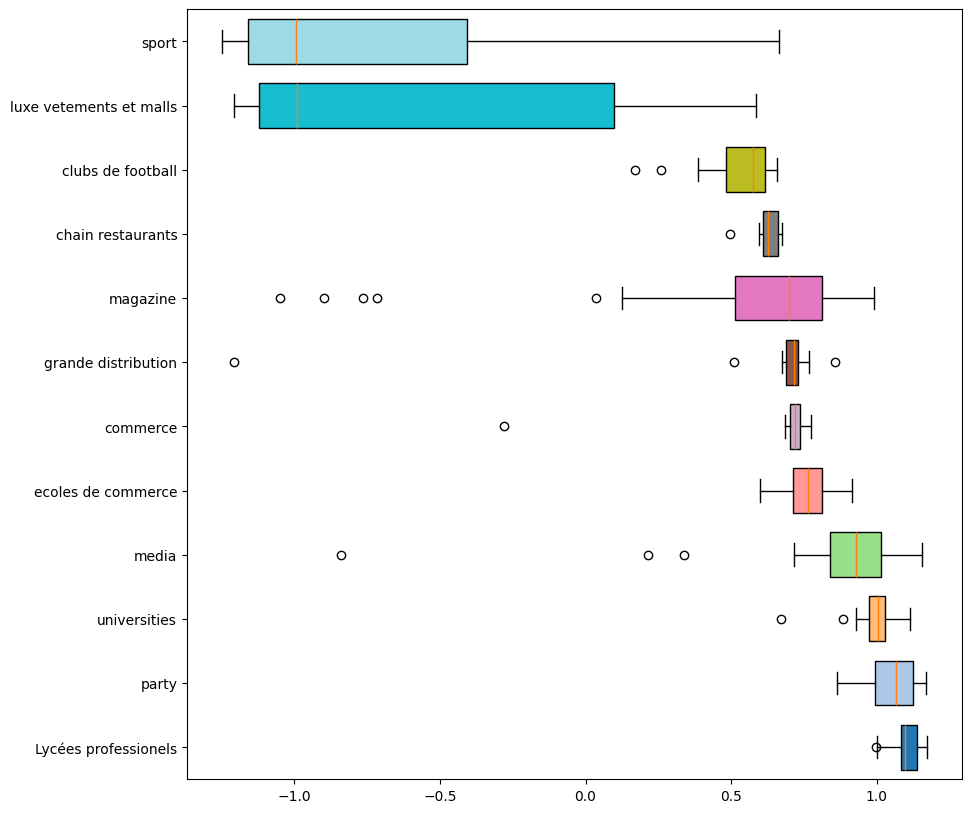

In [100]:
import matplotlib.pyplot as plt

# Create a DataFrame that maps twitter_name to type
twitter_name_to_type = unique_marker_df.set_index('twitter_name')['type']

# Add a 'type' column to column_coordinates
column_coordinates['type'] = twitter_name_to_type

# Calculate the median x-axis value for each type and sort in descending order
type_order = column_coordinates.groupby('type')[0].median().sort_values(ascending=False).index

# Create a color map
cmap = plt.get_cmap('tab20', len(type_order))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Create a box plot for each type
for i, type_ in enumerate(type_order):
    data = column_coordinates[column_coordinates['type'] == type_][0]
    ax.boxplot(data, positions=[i], patch_artist=True, boxprops=dict(facecolor=cmap(i)), vert=False, widths=0.7)

# Set the y-axis labels and limit
ax.set_yticks(range(len(type_order)))
ax.set_yticklabels(type_order)

plt.show()

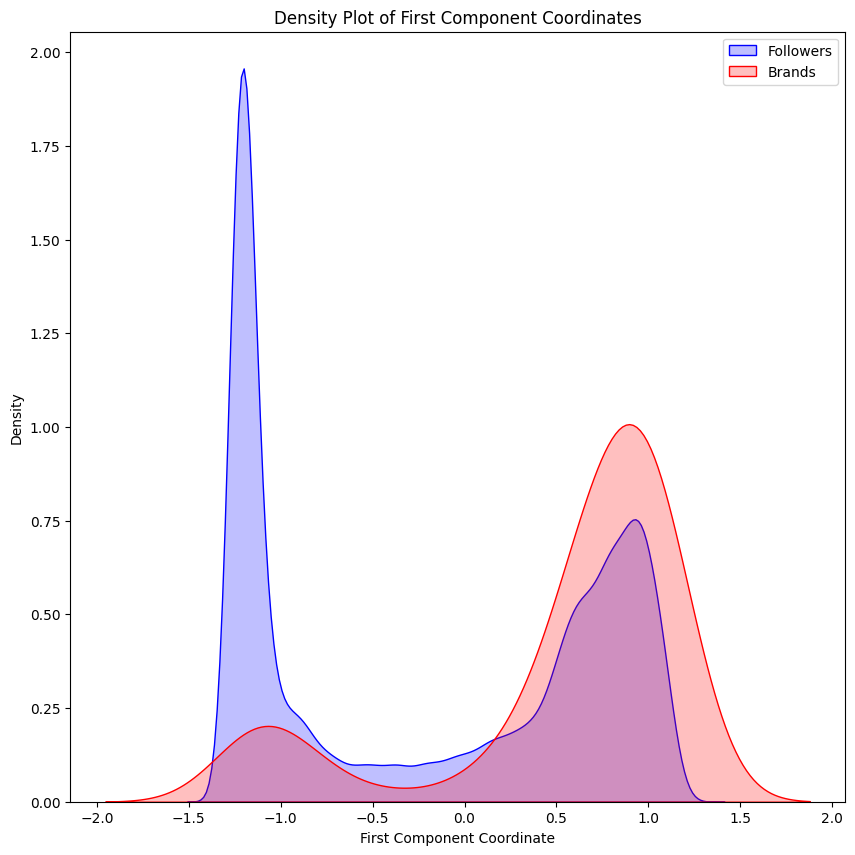

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the coordinates for the first component for followers and brands
first_component_followers = row_coordinates.iloc[:, 0]
first_component_brands = column_coordinates.iloc[:, 0]

plt.figure(figsize=(10, 10))

# Create a density plot for followers
sns.kdeplot(first_component_followers, fill=True, color='b', label='Followers')

# Create a density plot for brands
sns.kdeplot(first_component_brands, fill=True, color='r', label='Brands')

plt.xlabel('First Component Coordinate')
plt.title('Density Plot of First Component Coordinates')
plt.legend()

plt.show()

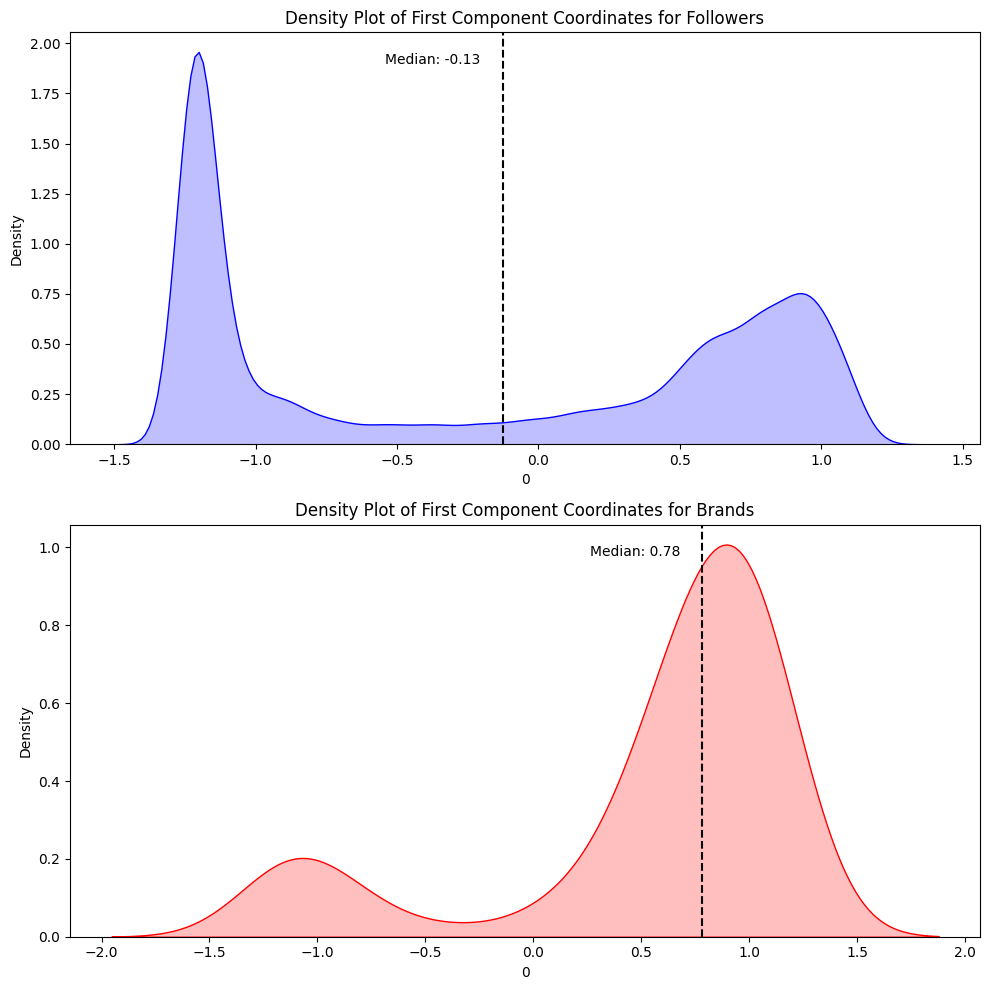

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the coordinates for the first component for followers and brands
first_component_followers = row_coordinates.iloc[:, 0]
first_component_brands = column_coordinates.iloc[:, 0]

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Create a density plot for followers
sns.kdeplot(first_component_followers, fill=True, color='b', ax=axs[0])
axs[0].axvline(first_component_followers.median(), color='k', linestyle='--')
axs[0].text(first_component_followers.median()-0.08, axs[0].get_ylim()[1]*0.95, f'Median: {first_component_followers.median():.2f}', ha='right', va='top')
axs[0].set_title('Density Plot of First Component Coordinates for Followers')

# Create a density plot for brands
sns.kdeplot(first_component_brands, fill=True, color='r', ax=axs[1])
axs[1].axvline(first_component_brands.median(), color='k', linestyle='--')
axs[1].text(first_component_brands.median()-0.1, axs[1].get_ylim()[1]*0.95, f'Median: {first_component_brands.median():.2f}', ha='right', va='top')
axs[1].set_title('Density Plot of First Component Coordinates for Brands')

plt.tight_layout()
plt.show()

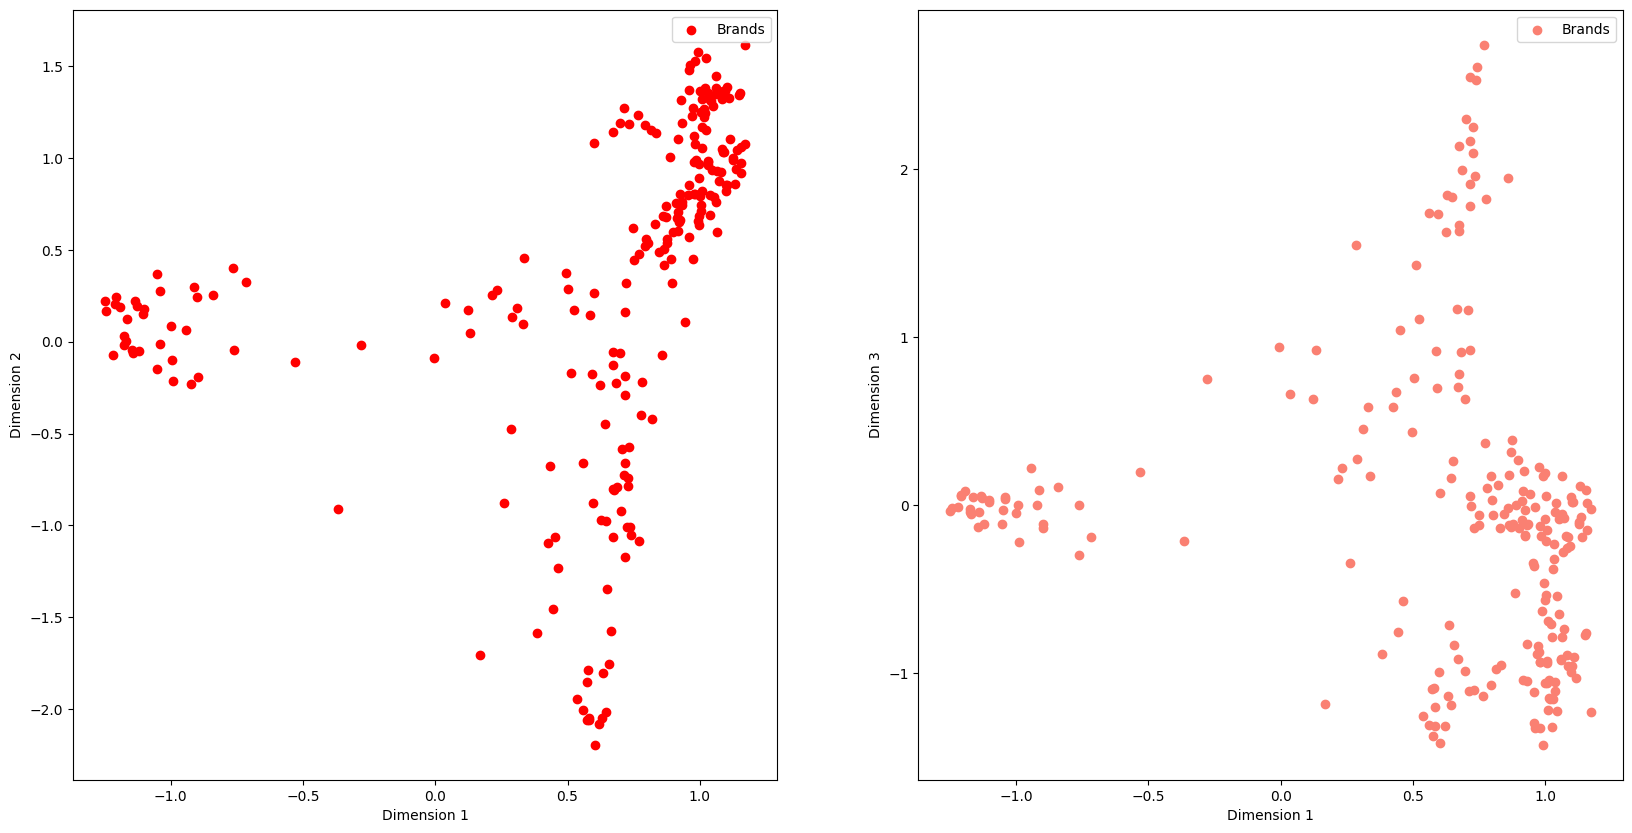

In [16]:
#dimensions agains each other for brands
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(column_coordinates[0], column_coordinates[1], color='red', label='Brands')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(column_coordinates[0], column_coordinates[2], color='salmon', label='Brands')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.legend()

plt.show()

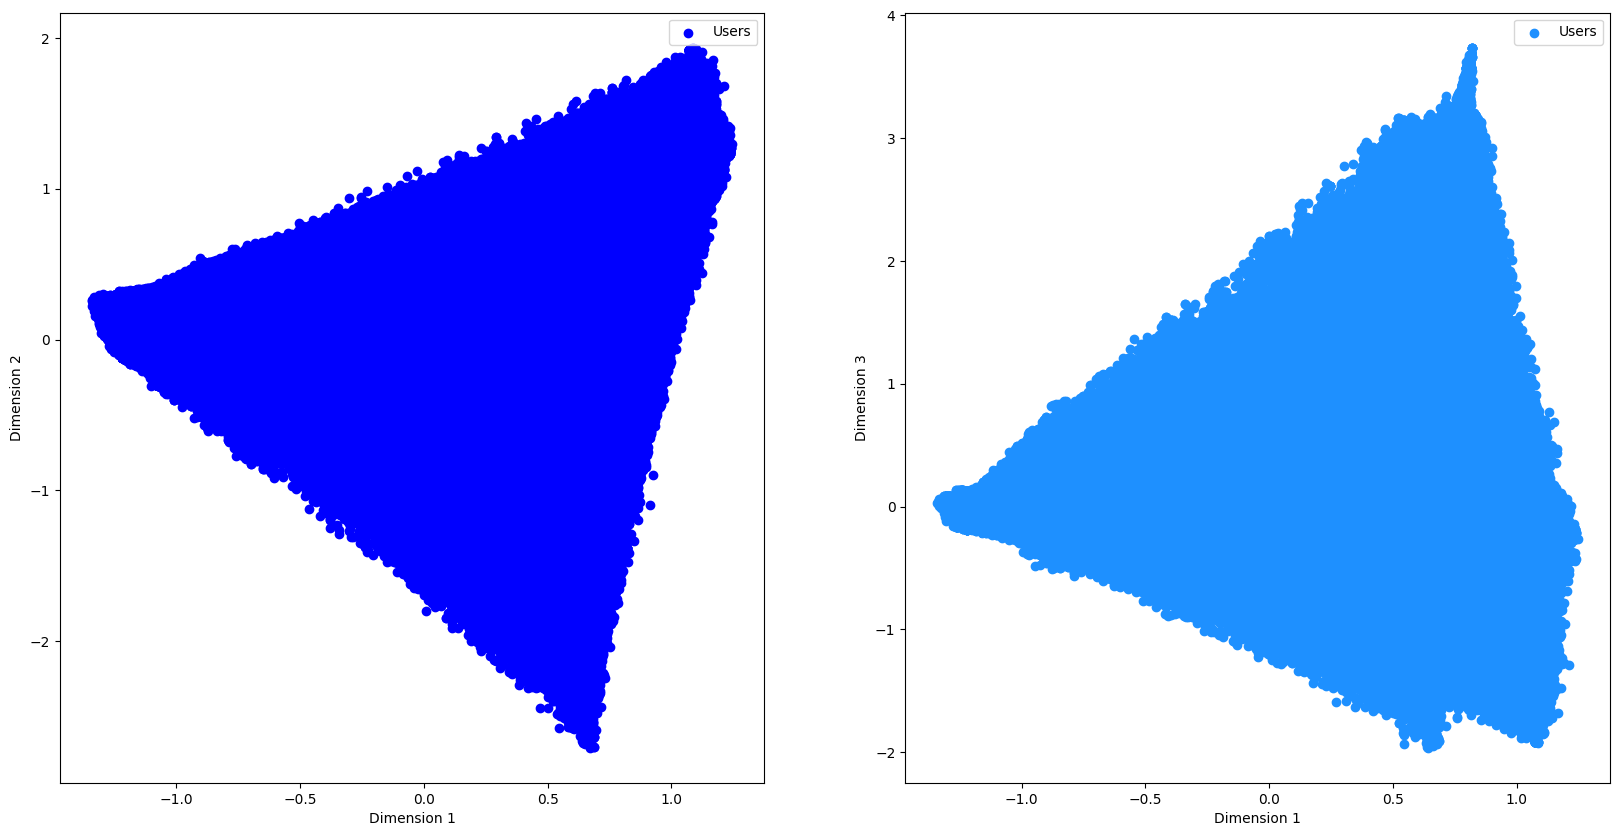

In [18]:
#dimensions agains each other for followers
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(row_coordinates[0], row_coordinates[1], color='blue', label='Users')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(row_coordinates[0], row_coordinates[2], color='dodgerblue', label='Users')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.legend()

plt.show()

/tmp/ipykernel_355338/4239639164.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))


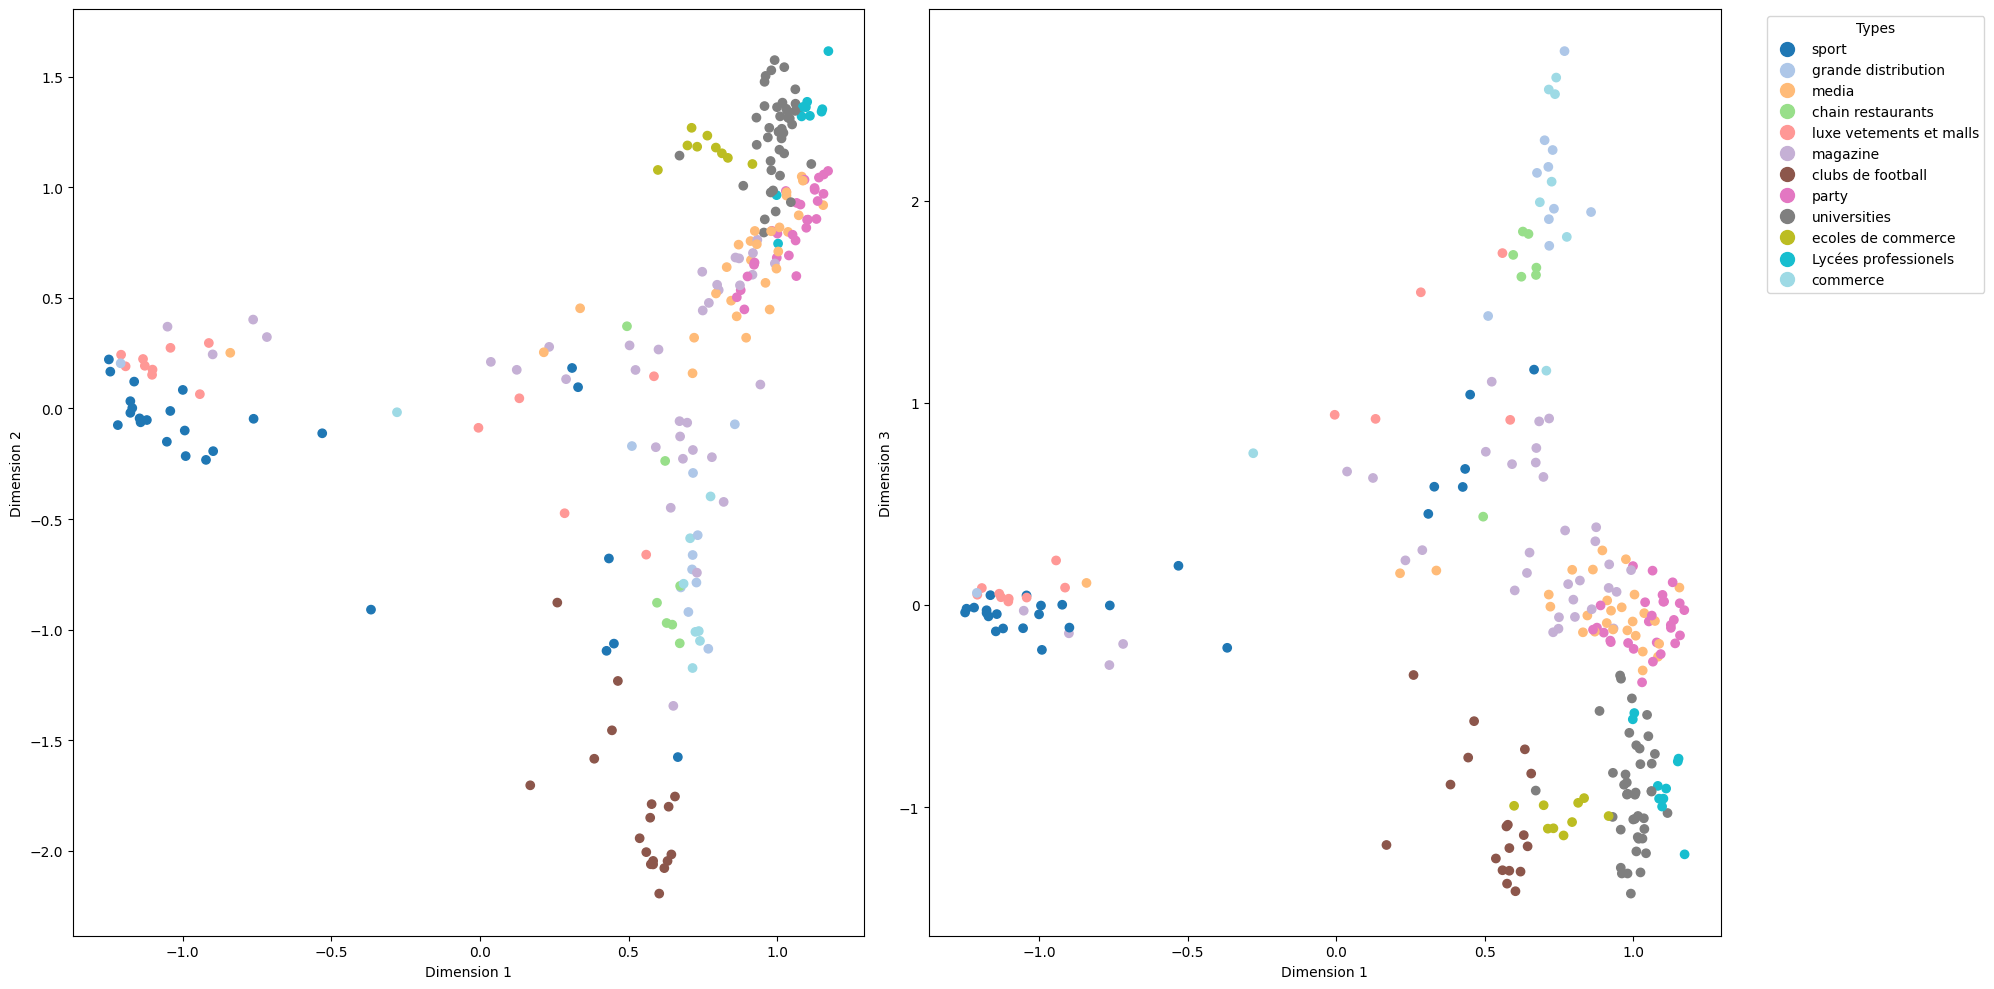

In [29]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

types = unique_marker_df['type'].unique()
cmap = cm.get_cmap('tab20', len(types))

# Get the colors for the brands
colors = unique_marker_df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

# Create a mapping of types to colors
type_color_mapping = {t: cmap(i) for i, t in enumerate(types)}

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(column_coordinates[0], column_coordinates[1], c=colors[column_coordinates.index])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(column_coordinates[0], column_coordinates[2], c=colors[column_coordinates.index])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')

# Create legend
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10) for color in type_color_mapping.values()]
plt.legend(legend_handles, type_color_mapping.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

plt.tight_layout()
plt.show()

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

def plot_type2(df, column_coordinates, type_to_plot, dim1, dim2):
    # Filter for the specified type
    type_df = df[df['type'] == type_to_plot]

    # Use only specified type twitter_names in column_coordinates
    column_coordinates_type = column_coordinates[column_coordinates.index.isin(type_df['twitter_name'])]

    types = df['type'].unique()
    cmap = cm.get_cmap('tab20', len(types))

    # Get the colors for the types
    colors = df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

    # Create a scatter plot
    plt.figure(figsize=(10, 10))

    scatter = plt.scatter(column_coordinates_type[dim1], column_coordinates_type[dim2], c=colors[column_coordinates_type.index])

    # Add labels
    texts = []
    for i, twitter_name in enumerate(column_coordinates_type.index):
        texts.append(plt.text(column_coordinates_type[dim1][i], column_coordinates_type[dim2][i], twitter_name))

    # Adjust text to avoid overlaps
    adjust_text(texts)

    # Create a legend
    legend_elements = [Patch(facecolor=cmap(i), edgecolor=cmap(i), label=t) for i, t in enumerate(types)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

    plt.xlabel(f'Dimension {dim1+1}')
    plt.ylabel(f'Dimension {dim2+1}')

    plt.show()

/tmp/ipykernel_356833/4182450218.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))
/tmp/ipykernel_356833/4182450218.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(column_coordinates_type[dim1][i], column_coordinates_type[dim2][i], twitter_name))


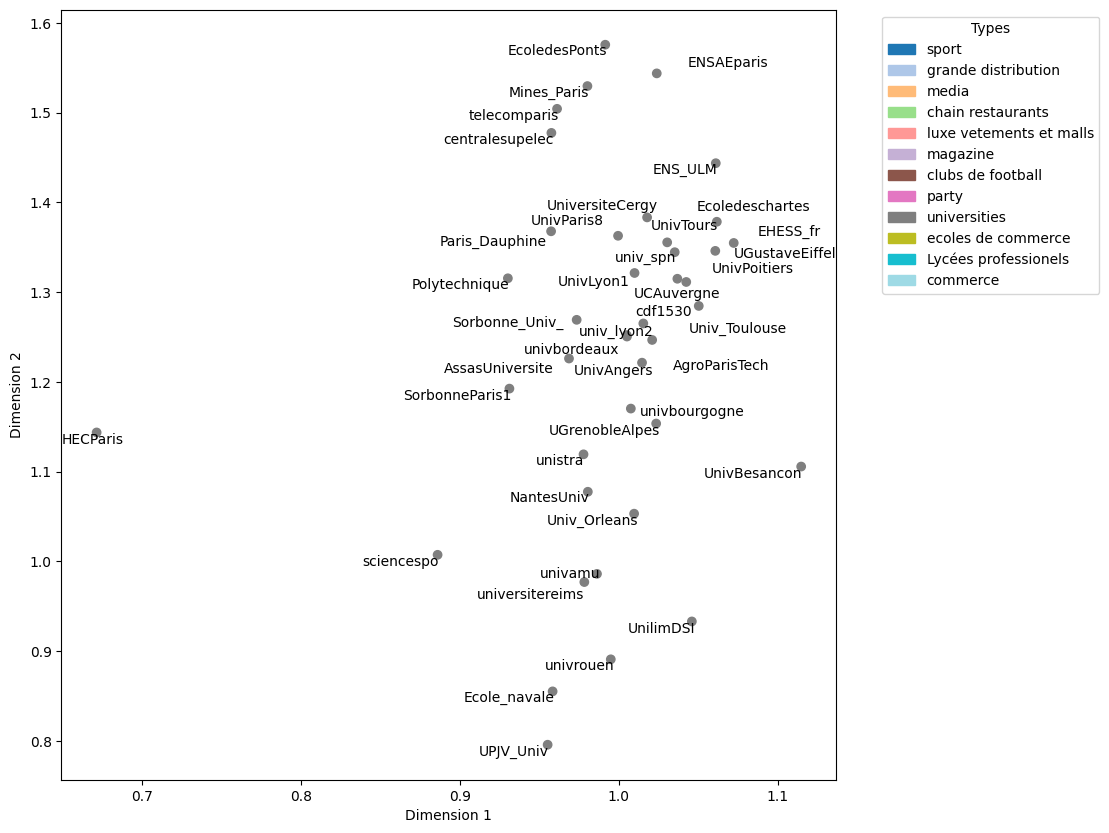

In [12]:
plot_type2(unique_marker_df, column_coordinates, 'universities', 0, 1)

In [46]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text

def plot_all_types_separately(df, column_coordinates, dim1, dim2):
    types = df['type'].unique()
    cmap = cm.get_cmap('tab20', len(types))

    # Create a subplot for each type
    fig, axs = plt.subplots(len(types), 1, figsize=(8, 7 * len(types)))  # Adjust the size here

    for ax, type_to_plot in zip(axs, types):
        # Filter for the specified type
        type_df = df[df['type'] == type_to_plot]

        # Use only specified type twitter_names in column_coordinates
        column_coordinates_type = column_coordinates[column_coordinates.index.isin(type_df['twitter_name'])]

        # Get the color for the type
        color = cmap(np.where(types == type_to_plot)[0][0])

        # Create a scatter plot with transparency and smaller point size
        scatter = ax.scatter(column_coordinates_type[dim1], column_coordinates_type[dim2], c=color, alpha=0.5, s=40)

        # Add labels with smaller font size
        texts = []
        for i, twitter_name in enumerate(column_coordinates_type.index):
            texts.append(ax.text(column_coordinates_type[dim1][i], column_coordinates_type[dim2][i], twitter_name, fontsize=8))

        # Adjust text to avoid overlaps
        adjust_text(texts, ax=ax)

        # Set the title, x-label, and y-label
        ax.set_title(f'Type: {type_to_plot}')
        ax.set_xlabel(f'Dimension {dim1+1}')
        ax.set_ylabel(f'Dimension {dim2+1}')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_356833/2377829706.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))
/tmp/ipykernel_356833/2377829706.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(column_coordinates_type[dim1], column_coordinates_type[dim2], c=color, alpha=0.5, s=40)
/tmp/ipykernel_356833/2377829706.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

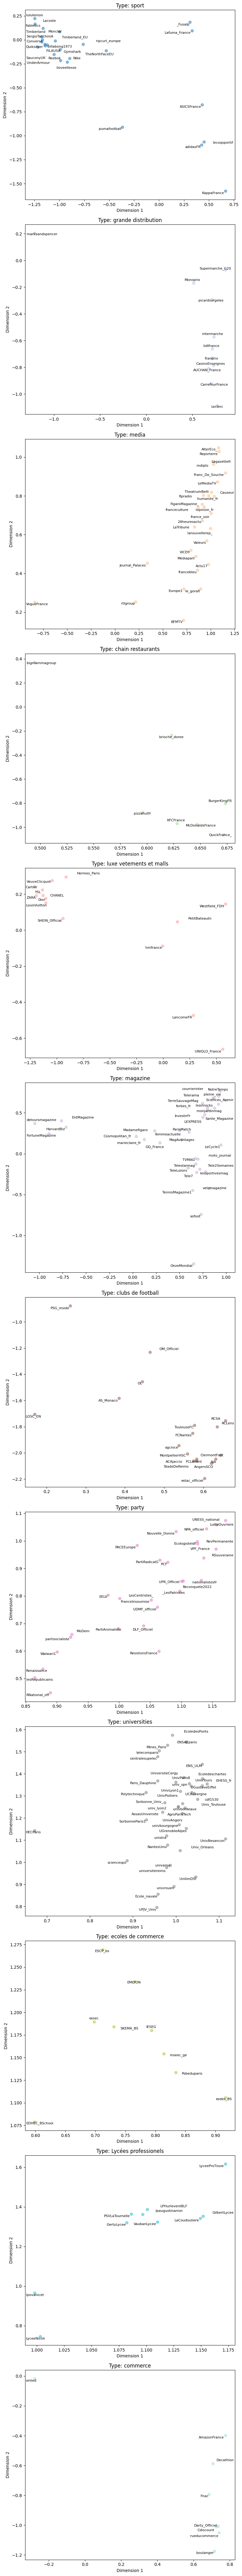

In [47]:
plot_all_types_separately(unique_marker_df, column_coordinates, 0, 1)

In [13]:
# Get the absolute coordinates of the brands on the first dimension
abs_column_coordinates = column_coordinates[0].abs()

# Sort the brands by their absolute coordinates in descending order
sorted_brands = abs_column_coordinates.sort_values(ascending=False)

# Print the brands that have contributed the most to the variance explained by the first dimension
print("Brands that have contributed the most to the variance explained by Dimension 1:\n", sorted_brands)

Brands that have contributed the most to the variance explained by Dimension 1:
 twitter_name
lululemon          1.248150
Fabletics          1.243343
SauconyUK          1.217986
marksandspencer    1.208514
Cartier            1.207065
                     ...   
LOSC_EN            0.169335
PetitBateautn      0.132607
marieclaire_fr     0.123947
Cosmopolitan_fr    0.036829
hmfrance           0.004885
Name: 0, Length: 235, dtype: float64


In [114]:
# Calculate the square of each brand's coordinate
squared_coordinates = sorted_brands**2

# Calculate the sum of the squares of all the brand coordinates
total_squared_coordinates = squared_coordinates.sum()

# Calculate the percentage contribution of each brand
percentage_contributions = (squared_coordinates / total_squared_coordinates) * 100

# Print the percentage contributions
print("Percentage contributions of the brands to the variance explained by Dimension 1:\n", percentage_contributions)

Percentage contributions of the brands to the variance explained by Dimension 1:
 twitter_name
lululemon          0.844794
Fabletics          0.838299
SauconyUK          0.804455
marksandspencer    0.791991
Cartier            0.790094
ZARA               0.770285
SergioTacchiniA    0.749827
Timberland         0.749819
LyceeProTissie     0.745152
UNESS_national     0.743826
Converse           0.741587
Lacoste            0.733542
NPA_officiel       0.725587
VPF_France         0.724488
Franc_De_Souche    0.723135
GilbertLycee       0.719561
LaCoudouliere      0.716344
billabong1973      0.710697
FILAUSA            0.706528
LutteOuvriere      0.705290
RSouveraine        0.699974
YSL                0.696424
Reconquete2022     0.694955
CHANEL             0.689035
RevPermanente      0.687803
EcologisteIdf      0.687324
Quiksilver         0.680627
UnivBesancon       0.673858
VaubanLycee        0.668265
UPR_Officiel       0.659961
LouisVuitton       0.659535
Dior               0.657755
LPHurleve

In [112]:
pd.set_option('display.max_rows', None)
sorted_brands

twitter_name
lululemon          1.248150
Fabletics          1.243343
SauconyUK          1.217986
marksandspencer    1.208514
Cartier            1.207065
ZARA               1.191838
SergioTacchiniA    1.175904
Timberland         1.175898
LyceeProTissie     1.172233
UNESS_national     1.171189
Converse           1.169425
Lacoste            1.163065
NPA_officiel       1.156741
VPF_France         1.155864
Franc_De_Souche    1.154785
GilbertLycee       1.151928
LaCoudouliere      1.149350
billabong1973      1.144810
FILAUSA            1.141448
LutteOuvriere      1.140447
RSouveraine        1.136141
YSL                1.133256
Reconquete2022     1.132060
CHANEL             1.127229
RevPermanente      1.126220
EcologisteIdf      1.125828
Quiksilver         1.120330
UnivBesancon       1.114745
VaubanLycee        1.110109
UPR_Officiel       1.103191
LouisVuitton       1.102834
Dior               1.101345
LPHurleventBLF     1.100932
nationalistesfr    1.100666
_LesPatriotes      1.097926
lpaugus

In [113]:
sorted_brands.shape

(235,)